In [1]:
# numpy and pandas for data manipulation
import numpy as np
import pandas as pd 
from pandas_profiling import ProfileReport

from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

# sklearn preprocessing for dealing with categorical variables
from sklearn import metrics
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, PolynomialFeatures, OneHotEncoder, StandardScaler, FunctionTransformer, RobustScaler, OrdinalEncoder
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
import lightgbm as lgb
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
# imbalanced sampler
from imblearn.under_sampling  import RandomUnderSampler

# File system manangement
import os

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# plotting
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def data_resampler(df_train, target):
    """resample dataset from imbalanced target shape"""
    rsp = RandomUnderSampler()
    X_rsp, y_rsp = rsp.fit_resample(df_train, target)
    return X_rsp, y_rsp

In [3]:
def echantillonage(X, y):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    
    return X_train, X_test, y_train, y_test

In [56]:
def cf_matrix_roc_auc(model, y_true, y_pred, y_pred_proba, feature_importances):
    '''This function will make a pretty plot of 
      an sklearn Confusion Matrix using a Seaborn heatmap visualization + ROC Curve.'''
    print("Detail:")
    print(metrics.classification_report(y_true, y_pred))
    
    fig = plt.figure(figsize=(20,15))
  
    plt.subplot(221)
    cf_matrix = metrics.confusion_matrix(y_true, y_pred)
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
  
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')
    
    roc_auc = metrics.roc_auc_score(y_true, y_pred_proba)
    plt.subplot(222)
    fpr,tpr,_ = metrics.roc_curve(y_true, y_pred_proba)
    plt.plot(fpr, tpr, color='orange', linewidth=5, label='AUC = %0.4f' %roc_auc)
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()

    if feature_importances : 
        #plt.subplot(212)
        xgb.plot_importance(model.named_steps['classifier'], max_num_features=20, height=0.2)
        plt.xticks(rotation=90)

    plt.show()

# Train / Test split

 - On équilibre en volume les représentants de chaque classe.
 - On selectionne un sous échantillon (~6k clients) pour réduire l'empreinte mémoire et prototyper plus rapidement.
 - On split le jeu de donnée pour train et test.

In [4]:
raw_train_df = pd.read_csv("data/application_train.csv")

In [5]:
resample_X, resample_y = data_resampler( raw_train_df, raw_train_df['TARGET'] )

In [6]:
resample_X = resample_X.sample(10000)
id_ = resample_X['SK_ID_CURR'] 
y_raw = resample_X['TARGET'] 
X_raw = resample_X.drop(['SK_ID_CURR', 'TARGET'], axis=1)

In [7]:
X_train, X_test, y_train, y_test = echantillonage(X_raw, y_raw)

In [8]:
for x in [X_train, X_test]:
    print(x.shape)

(8000, 120)
(2000, 120)


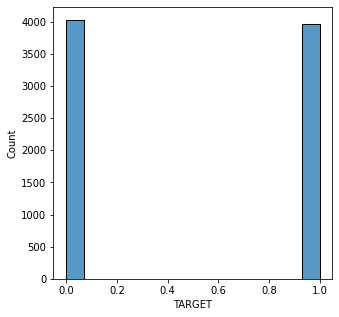

In [9]:
df_X = X_train.copy()
df_X['TARGET'] = y_train
fig, ax = plt.subplots(figsize=(5, 5))
ax = sns.histplot(data=df_X, x="TARGET")
plt.show()

# Preprocessor

In [10]:
raw_train_df.select_dtypes(include=['category', 'object'])

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE,FONDKAPREMONT_MODE,HOUSETYPE_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE
0,Cash loans,M,N,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Laborers,WEDNESDAY,Business Entity Type 3,reg oper account,block of flats,"Stone, brick",No
1,Cash loans,F,N,N,Family,State servant,Higher education,Married,House / apartment,Core staff,MONDAY,School,reg oper account,block of flats,Block,No
2,Revolving loans,M,Y,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Laborers,MONDAY,Government,NaN,NaN,NaN,NaN
3,Cash loans,F,N,Y,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,Laborers,WEDNESDAY,Business Entity Type 3,NaN,NaN,NaN,NaN
4,Cash loans,M,N,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Core staff,THURSDAY,Religion,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,Cash loans,M,N,N,Unaccompanied,Working,Secondary / secondary special,Separated,With parents,Sales staff,THURSDAY,Services,reg oper account,block of flats,"Stone, brick",No
307507,Cash loans,F,N,Y,Unaccompanied,Pensioner,Secondary / secondary special,Widow,House / apartment,NaN,MONDAY,XNA,reg oper account,block of flats,"Stone, brick",No
307508,Cash loans,F,N,Y,Unaccompanied,Working,Higher education,Separated,House / apartment,Managers,THURSDAY,School,reg oper account,block of flats,Panel,No
307509,Cash loans,F,N,Y,Unaccompanied,Commercial associate,Secondary / secondary special,Married,House / apartment,Laborers,WEDNESDAY,Business Entity Type 1,NaN,block of flats,"Stone, brick",No


In [11]:
class FormatTransformer(BaseEstimator, TransformerMixin):
    num_attrs = []
    cat_attrs = []
    
    cols = []
    encoders = {}
    
    encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)
    
    
    def fit(self, X, y=None):
        #print("fit formatter")
        self.cols= X.select_dtypes(include=['category', 'object']).columns
        self.encoder.fit(X[self.cols])
        
        return self
    
    def transform(self, X):
        #print("transform formatter")
        X_ = X.copy()
        
        # VALEURS ABERRANTES
        # Create an anomalous flag column
        X_['DAYS_EMPLOYED_ANOM'] = X_["DAYS_EMPLOYED"] == 365243
        X_["DAYS_EMPLOYED_ANOM"] = X_["DAYS_EMPLOYED_ANOM"].astype("int")
        
        # Replace the anomalous values with nan
        X_['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)
        # Traitement des valeurs négatives
        X_['DAYS_BIRTH'] = abs(X_['DAYS_BIRTH'])
        
        #Label Encoding
        #for key, encoder in self.encoders.items():
        #    X_[key] = encoder.transform(X_[key])
        
        print(X_.shape)
        # OneHotEncoding
        X_[self.cols] = self.encoder.transform(X_[self.cols])
        
        for col in [c for c in self.cols if c not in X_.columns]:
            X_[col] = 0
            
        #print(X_.shape)
        return X_

In [12]:
class ImputerTransformer(BaseEstimator, TransformerMixin):
    imputer = SimpleImputer(strategy='median')
    
    def fit(self, X, y=None):
        #print("fit imputer")       
        self.imputer.fit(X)
        return self
    
    def transform(self, X):
        #print("transform imputer")
        X_ = X.copy()        
        X_= pd.DataFrame(self.imputer.transform(X_), index=X_.index, columns=X_.columns)
        #print(X_.shape)
        return X_

In [13]:
class FeatureTransformer(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        #print("fit feature")        
        return self
    
    def transform(self, X):
        #print("transform feature")
        X_ = X.copy()   
        # CREATION DE VARIABLE
        # CREDIT_INCOME_PERCENT: the percentage of the credit amount relative to a client's income
        # ANNUITY_INCOME_PERCENT: the percentage of the loan annuity relative to a client's income
        # CREDIT_TERM: the length of the payment in months (since the annuity is the monthly amount due
        # DAYS_EMPLOYED_PERCENT: the percentage of the days employed relative to the client's age
        # Again, thanks to Aguiar and his great script for exploring these features.
        X_['CREDIT_INCOME_PERCENT'] = X_['AMT_CREDIT'] / X_['AMT_INCOME_TOTAL']
        X_['ANNUITY_INCOME_PERCENT'] = X_['AMT_ANNUITY'] / X_['AMT_INCOME_TOTAL']
        X_['CREDIT_TERM'] = X_['AMT_ANNUITY'] / X_['AMT_CREDIT']
        X_['DAYS_EMPLOYED_PERCENT'] = X_['DAYS_EMPLOYED'] / X_['DAYS_BIRTH']
        #print(X_.shape)
        return X_

In [14]:
class ScallerTransformer(BaseEstimator, TransformerMixin):
       
    #scaller = MinMaxScaler(feature_range = (0, 1))
    scaller = MinMaxScaler()
    
    
    
    def fit(self, X, y=None):
        #print("fit scaller")    
        self.scaller.fit(X)      
        return self
    
    def transform(self, X):
        #print("transform scaller")
        X_ = X.copy()      
        
        X_ = pd.DataFrame(self.scaller.transform(X_), index=X_.index, columns=X_.columns)
        #print(X_.shape)
        return X_

In [15]:
class KNeighborsTransformer(BaseEstimator, TransformerMixin):
       
    #scaller = MinMaxScaler(feature_range = (0, 1))
    knn = KNeighborsClassifier(300)
    cols = ['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3','AMT_ANNUITY', 'AMT_CREDIT']
    y_ = []
    
    def fit(self, X, y):
        #print("fit KNN")
        self.y_ = y  
        self.knn.fit(X[self.cols], y)        
        return self
    
    def transform(self, X):
        #print("transform KNN")
        X_ = X.copy()         
                      
        X_['KNN_300'] = [self.y_.iloc[ele].mean() for ele in self.knn.kneighbors(X_[self.cols])[1]]
        
        #print(X_.shape)
        return X_

In [16]:
class MetaTransformer(BaseEstimator, TransformerMixin):
    
    preprocessor_pipeline = Pipeline(steps=[
        ('format', FormatTransformer()),
        ('impute', ImputerTransformer()),
        ('feature',FeatureTransformer()),
        ('scale', ScallerTransformer()),
        ('knn', KNeighborsTransformer()),
        ])
    
    def fit(self, X, y):
        #print("meta _ fit transformers")
        
        self.preprocessor_pipeline.fit(X, y)
        
        return self
    
    def transform(self, X):
        #print("meta _ transform X")
        X_ = X.copy()        
        return self.preprocessor_pipeline.transform(X_)
    
    def inverse_transform(Xt):
        #print("inverse transform ...")
        return self.preprocessor_pipeline.inverse_transform(Xt)

In [17]:
preprocessor = MetaTransformer()

In [18]:
Xt_train = preprocessor.fit_transform(X_train, y_train)

(8000, 121)
(8000, 121)


In [19]:
Xt_train

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,...,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,DAYS_EMPLOYED_ANOM,CREDIT_INCOME_PERCENT,ANNUITY_INCOME_PERCENT,CREDIT_TERM,DAYS_EMPLOYED_PERCENT,KNN_300
1600,0.0,0.0,1.0,0.0,0.333333,0.106280,0.116431,0.139611,0.096610,1.000000,...,0.0,0.000000,0.000000,0.2500,0.0,0.043126,0.080677,0.514304,0.637405,0.333333
3615,0.0,0.0,0.0,0.0,0.000000,0.130435,0.143418,0.234915,0.155932,1.000000,...,0.0,0.117647,0.000000,0.4375,0.0,0.043297,0.111402,0.759311,0.486775,0.236667
37774,0.0,0.0,1.0,1.0,0.333333,0.045894,0.173224,0.132714,0.152542,1.000000,...,0.0,0.000000,0.000000,0.1250,0.0,0.129277,0.163762,0.270121,0.895546,0.540000
26004,0.0,1.0,0.0,0.0,0.000000,0.033816,0.140301,0.106578,0.152542,1.000000,...,0.0,0.000000,0.000000,0.1250,0.0,0.133520,0.169535,0.270654,0.853046,0.716667
2018,0.0,0.0,0.0,1.0,0.000000,0.045894,0.159007,0.066115,0.172881,0.833333,...,0.0,0.000000,0.000000,0.0625,0.0,0.119303,0.086781,0.074725,0.485283,0.210000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4048,0.0,0.0,0.0,1.0,0.000000,0.094203,0.172217,0.149103,0.159322,1.000000,...,0.0,0.000000,0.000000,0.0625,0.0,0.070014,0.096890,0.326642,0.938590,0.176667
9578,0.0,0.0,0.0,1.0,0.000000,0.053140,0.140301,0.183866,0.152542,0.833333,...,0.0,0.000000,0.000000,0.1875,1.0,0.094462,0.197896,0.576759,0.908347,0.726667
43330,0.0,1.0,0.0,1.0,0.000000,0.105435,0.156762,0.205090,0.152542,0.166667,...,0.0,0.000000,0.000000,0.0000,0.0,0.057699,0.119429,0.576448,0.955988,0.596667
20289,0.0,0.0,0.0,1.0,0.000000,0.057971,0.029557,0.060211,0.025424,1.000000,...,0.0,0.000000,0.000000,0.1250,0.0,0.023211,0.064900,0.846305,0.986407,0.490000


# Estimator XGBoost

## config

In [80]:
params = {
    'classifier__learning_rate': [0.01, 0.03, 0.05, 0.08, 0.1],
    'classifier__n_estimators': [300],
    'classifier__max_depth': [3, 4, 5, 6],
    'classifier__subsample': [0.8],
    'classifier__colsample_bytree': [0.6],
    'classifier__gamma': [1],
    'classifier__objective': ["binary:logistic"],
}

In [81]:
from sklearn.metrics import make_scorer, precision_score, recall_score, roc_auc_score, fbeta_score, f1_score

In [82]:
## Si on cherche a eviter de mal catégoriser les clients à risque de défault (limiter le nombre de faux négatif) >> on maxime le recall

recall_scorer = make_scorer(recall_score, greater_is_better=True)

In [83]:
## Si on cherche a augmenter le nombre de clien potentiel (limiter le nombre de faux positif) >> on maxime le precision

precision_scorer = make_scorer(precision_score, greater_is_better=True)

In [84]:
## Si on cherche a maximiser les 2 critéres, mais en donnant en donnant plus d'importance au recall >> on maximise fbeta_score

fbeta_scorer = make_scorer(fbeta_score, greater_is_better=True, beta=2)

In [84]:
def score_f(y_t, y_p, sample_weight):
    return roc_auc_score(y_t.values, y_p, sample_weight=sample_weight.loc[y_t.index.values].values.reshape(-1))

scoring = make_scorer(score_f, sample_weight=my_sample_weight)

In [85]:
scoring_ = {
    'recall': recall_scorer,
    'precision' : precision_scorer,
    'fbeta': fbeta_scorer
}
best_params = {}
best_models= {}
model_scores = {}

## Base estimator :: no preprocessing

In [86]:
no_processing_pipeline = Pipeline(steps = [
    ('format', FormatTransformer()),
    ('transform', ImputerTransformer()),
    ('classifier', xgb.XGBClassifier())])

In [87]:
grid = GridSearchCV(no_processing_pipeline, param_grid=params, cv=5)

grid.fit(X_train, y_train)

(6400, 121)
[14:55:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
(1600, 121)
(6400, 121)
[14:55:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
(1600, 121)
(6400, 121)
[14:55:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
(1600, 121

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('format', FormatTransformer()),
                                       ('transform', ImputerTransformer()),
                                       ('classifier',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      enable_categorical=False,
                                                      gamma=None, gpu_id=None,
                                                      importance_type=None,
                                                      interaction_constraints=None,
                                                      learning_rate=None...
             

In [88]:
best_models['no_process'] = grid.best_estimator_    
model_scores['no_process'] = grid.score(X_test, y_test)
best_params['no_process'] = grid.best_params_

(2000, 121)


In [89]:
grid.score(X_test, y_test)

(2000, 121)


0.676

## Standard estimator :: 

In [90]:
estimator_pipeline = Pipeline(steps = [
                ('transform', MetaTransformer()),
                ('classifier', xgb.XGBClassifier())])

In [91]:
grid = GridSearchCV(estimator_pipeline, param_grid=params, cv=5)

grid.fit(X_train, y_train)

(6400, 121)
(6400, 121)
[14:58:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
(1600, 121)
(6400, 121)
(6400, 121)
[14:58:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
(1600, 121)
(6400, 121)
(6400, 121)
[14:59:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to 

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('transform', MetaTransformer()),
                                       ('classifier',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      enable_categorical=False,
                                                      gamma=None, gpu_id=None,
                                                      importance_type=None,
                                                      interaction_constraints=None,
                                                      learning_rate=None,
                                                      max_delta_step=None,
               

In [92]:
best_models['base'] = grid.best_estimator_    
model_scores['base'] = grid.score(X_test, y_test)
best_params['base'] = grid.best_params_

(2000, 121)


In [93]:
grid.score(X_test, y_test)

(2000, 121)


0.679

## Custom estimator :: custom score function

In [94]:
estimator_pipeline = Pipeline(steps = [
                ('transform', MetaTransformer()),
                ('classifier', xgb.XGBClassifier())])

In [95]:
for sc_name, sc_func in scoring_.items():
    grid = GridSearchCV(estimator_pipeline, param_grid=params, cv=5, scoring=sc_func)    
    grid.fit(X_train, y_train)
    best_models[sc_name] = grid.best_estimator_    
    best_params[sc_name] = grid.best_params_
    model_scores[sc_name] = grid.score(X_test, y_test)

(6400, 121)
(6400, 121)
[15:06:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
(1600, 121)
(6400, 121)
(6400, 121)
[15:06:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
(1600, 121)
(6400, 121)
(6400, 121)
[15:06:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to 

In [96]:
model_scores

{'no_process': 0.676,
 'base': 0.679,
 'recall': 0.6865520728008089,
 'precision': 0.6740220661985958,
 'fbeta': 0.6829611748139207}

In [97]:
score_table = pd.DataFrame()

----------------------------------------------------------------------
(2000, 121)
(2000, 121)
{'model_name': ['no_process'], 'recall ': [0.6693629929221436], 'precision ': [0.6734486266531028], 'fbeta_2 ': [0.6701761490180198], 'roc_auc': [0.7398315196138734]}
Detail:
              precision    recall  f1-score   support

           0       0.68      0.68      0.68      1011
           1       0.67      0.67      0.67       989

    accuracy                           0.68      2000
   macro avg       0.68      0.68      0.68      2000
weighted avg       0.68      0.68      0.68      2000



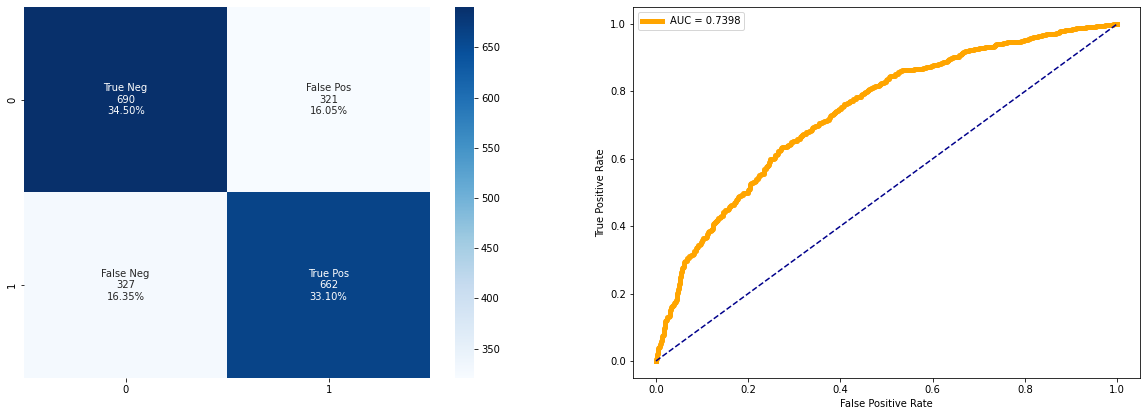

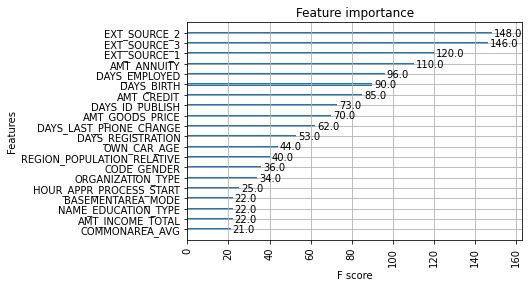

----------------------------------------------------------------------
(2000, 121)
(2000, 121)
{'model_name': ['base'], 'recall ': [0.679474216380182], 'precision ': [0.6740220661985958], 'fbeta_2 ': [0.6783767413688674], 'roc_auc': [0.7435269667629784]}
Detail:
              precision    recall  f1-score   support

           0       0.68      0.68      0.68      1011
           1       0.67      0.68      0.68       989

    accuracy                           0.68      2000
   macro avg       0.68      0.68      0.68      2000
weighted avg       0.68      0.68      0.68      2000



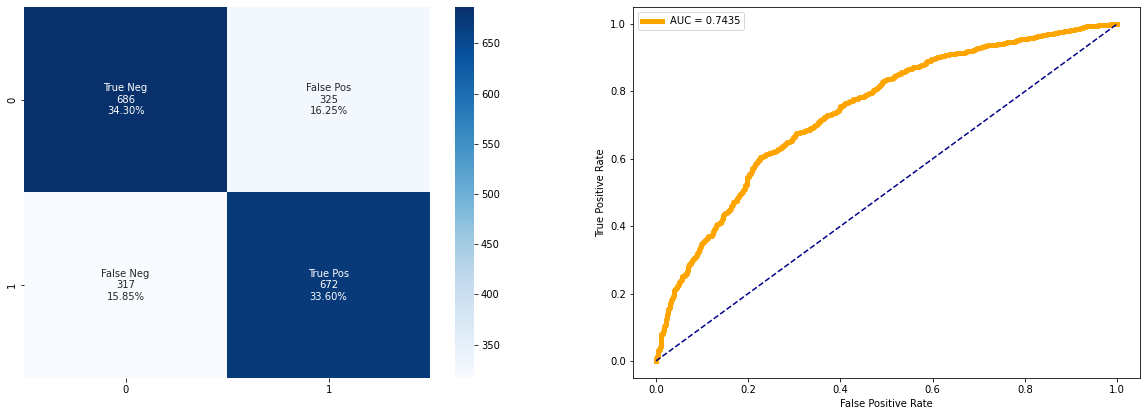

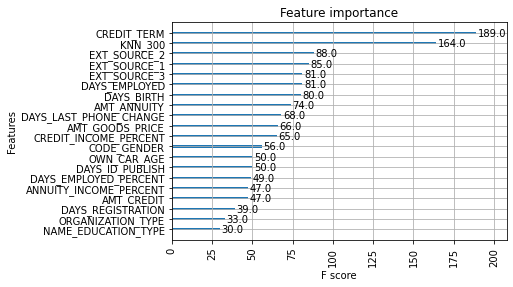

----------------------------------------------------------------------
(2000, 121)
(2000, 121)
{'model_name': ['recall'], 'recall ': [0.6865520728008089], 'precision ': [0.6689655172413793], 'fbeta_2 ': [0.6829611748139207], 'roc_auc': [0.7310064517806655]}
Detail:
              precision    recall  f1-score   support

           0       0.69      0.67      0.68      1011
           1       0.67      0.69      0.68       989

    accuracy                           0.68      2000
   macro avg       0.68      0.68      0.68      2000
weighted avg       0.68      0.68      0.68      2000



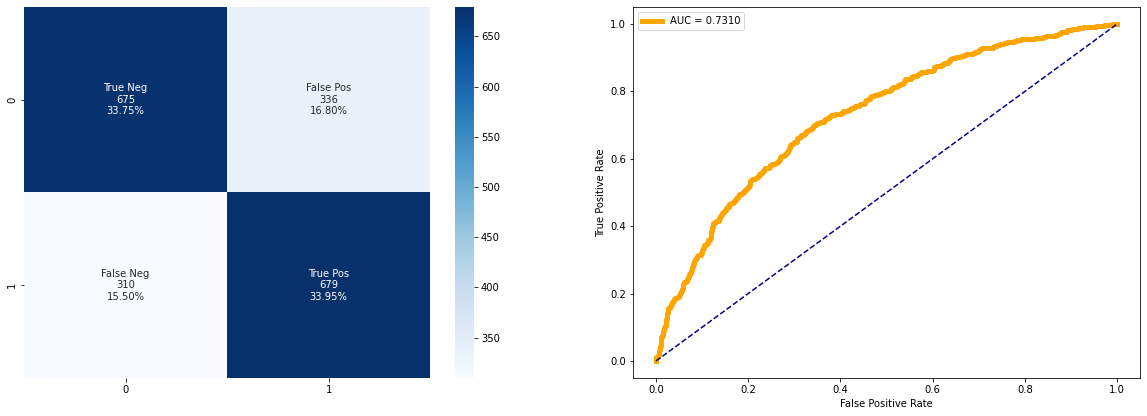

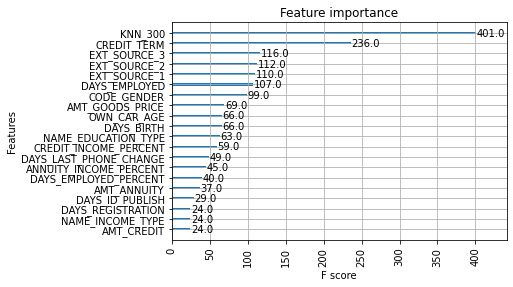

----------------------------------------------------------------------
(2000, 121)
(2000, 121)
{'model_name': ['precision'], 'recall ': [0.679474216380182], 'precision ': [0.6740220661985958], 'fbeta_2 ': [0.6783767413688674], 'roc_auc': [0.7435269667629784]}
Detail:
              precision    recall  f1-score   support

           0       0.68      0.68      0.68      1011
           1       0.67      0.68      0.68       989

    accuracy                           0.68      2000
   macro avg       0.68      0.68      0.68      2000
weighted avg       0.68      0.68      0.68      2000



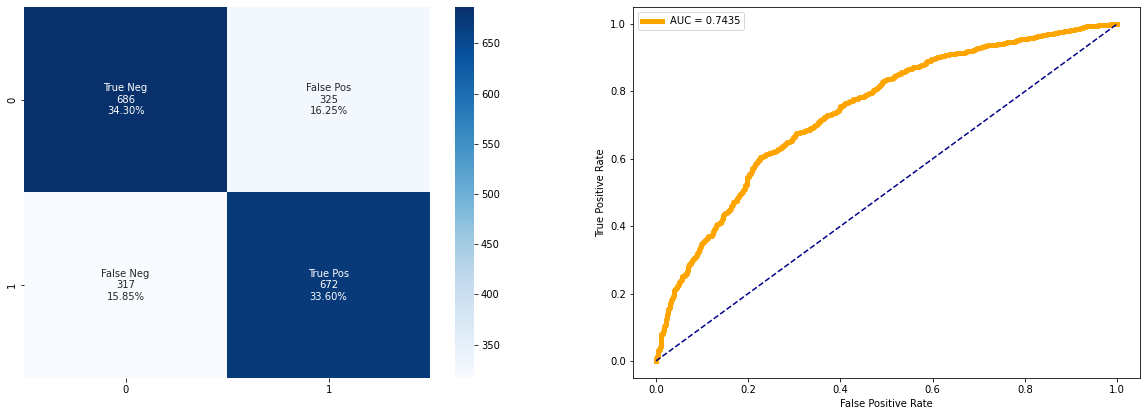

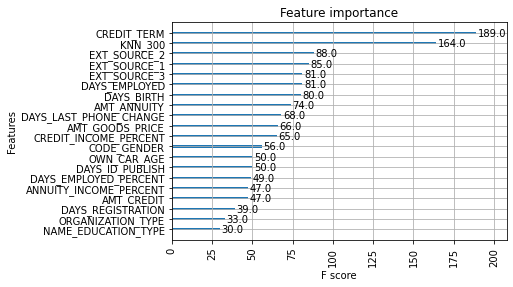

----------------------------------------------------------------------
(2000, 121)
(2000, 121)
{'model_name': ['fbeta'], 'recall ': [0.6865520728008089], 'precision ': [0.6689655172413793], 'fbeta_2 ': [0.6829611748139207], 'roc_auc': [0.7310064517806655]}
Detail:
              precision    recall  f1-score   support

           0       0.69      0.67      0.68      1011
           1       0.67      0.69      0.68       989

    accuracy                           0.68      2000
   macro avg       0.68      0.68      0.68      2000
weighted avg       0.68      0.68      0.68      2000



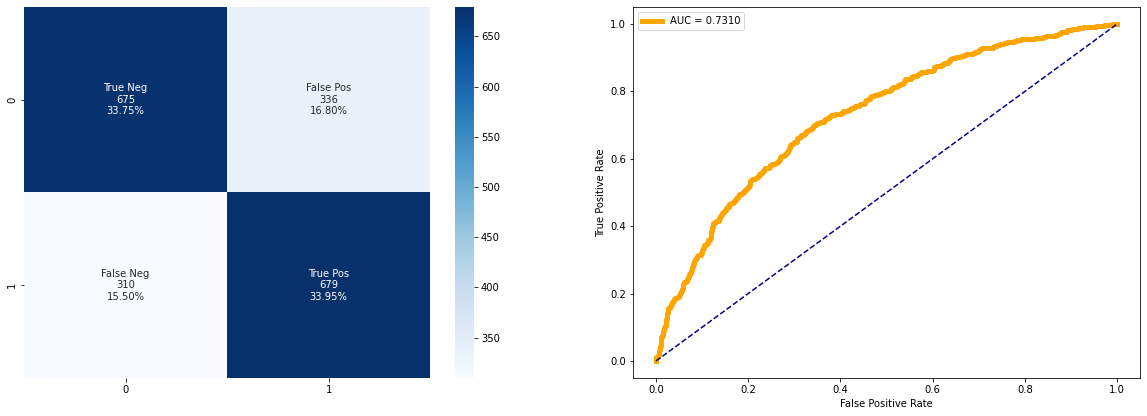

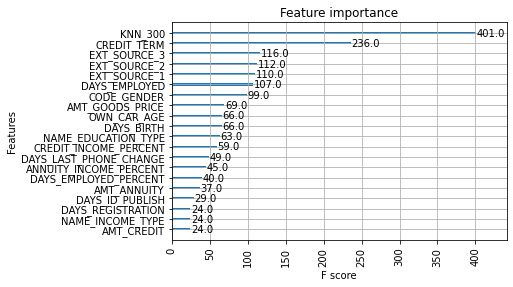

In [98]:
for m_name, model in best_models.items():
    print('-'*70)
    predicted = model.predict(X_test)
    predicted_prob = model.predict_proba(X_test)       
    
    d = {
        'model_name': [m_name],
        'recall ': [recall_score(y_test, predicted)],
        'precision ': [precision_score(y_test, predicted)],
        'fbeta_2 ': [fbeta_score(y_test, predicted, beta=2)],
        'roc_auc': [metrics.roc_auc_score(y_test, predicted_prob[:,1])]
    }
    print(d)
    cf_matrix_roc_auc(model, y_test, predicted, predicted_prob[:,1], feature_importances=True)
    
    score_table = pd.concat([score_table, pd.DataFrame(d)], ignore_index=True)

In [99]:
score_table

,model_name,recall,precision,fbeta_2,roc_auc
0,no_process,0.669363,0.673449,0.670176,0.739832
1,base,0.679474,0.674022,0.678377,0.743527
2,recall,0.686552,0.668966,0.682961,0.731006
3,precision,0.679474,0.674022,0.678377,0.743527
4,fbeta,0.686552,0.668966,0.682961,0.731006


In [100]:
best_params

{'no_process': {'classifier__colsample_bytree': 0.6,
  'classifier__gamma': 1,
  'classifier__learning_rate': 0.05,
  'classifier__max_depth': 3,
  'classifier__n_estimators': 300,
  'classifier__objective': 'binary:logistic',
  'classifier__subsample': 0.8},
 'base': {'classifier__colsample_bytree': 0.6,
  'classifier__gamma': 1,
  'classifier__learning_rate': 0.03,
  'classifier__max_depth': 3,
  'classifier__n_estimators': 300,
  'classifier__objective': 'binary:logistic',
  'classifier__subsample': 0.8},
 'recall': {'classifier__colsample_bytree': 0.6,
  'classifier__gamma': 1,
  'classifier__learning_rate': 0.01,
  'classifier__max_depth': 3,
  'classifier__n_estimators': 300,
  'classifier__objective': 'binary:logistic',
  'classifier__subsample': 0.8},
 'precision': {'classifier__colsample_bytree': 0.6,
  'classifier__gamma': 1,
  'classifier__learning_rate': 0.03,
  'classifier__max_depth': 3,
  'classifier__n_estimators': 300,
  'classifier__objective': 'binary:logistic',
  'c